# Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
pd.set_option('display.max_rows', 400) #replace n with the number of rows you want to see completely

# Datasets

In [3]:
aCryptoCurrencies = pd.read_csv('Data\cryptocurrencies.csv')['Symbol'].values

In [4]:
aModelTypes = pd.read_csv('Data\model types.csv')['Model Type'].values

In [5]:
dfOhlc = pd.read_csv('Data\dfOhlc.csv')
dfOhlc['timestamp'] = pd.DatetimeIndex(dfOhlc['timestamp'])
dfOhlc.set_index('timestamp', inplace=True)

# Descriptive Statistics

In [ ]:
dfDescriptiveStats = dfOhlc.filter(regex=':close').describe().round(2)

In [ ]:
dfDescriptiveStats.columns = dfDescriptiveStats.columns.str.replace(r":close", "")

In [ ]:
dfDescriptiveStats[aCryptoCurrencies]

# Experiments of Full Factorial Design

In [ ]:

sDesignType = 'Full Factorial Design'
dfResponses = pd.DataFrame()
for sModelType in aModelTypes:
    for sSymbol in aCryptoCurrencies:
            sExperimentsFilePath = 'Data\\' + sSymbol +'\\'+ sModelType + '\\'+ sDesignType + '\\Experiments.csv'
            dfExperiments =  pd.read_csv(sExperimentsFilePath, index_col = 'Run ID')
            dfExperiments['Model Type'] = sModelType
            dfExperiments['Exchange Rate'] = sSymbol
            dfResponses = dfResponses.append(dfExperiments)
dfResponses['Response'] = round(dfResponses['Response'],2)
dfResponses[list(dfResponses.iloc[:, -2:].columns) +list(dfResponses.iloc[:, :-2].columns)]


# Coefficient of Determination of 1st Order Models of 1st Order Models

In [ ]:
sDesignType = 'Steepest Descent'
dfTable = pd.DataFrame(columns = aModelTypes, index  = aCryptoCurrencies)
for sModelType in aModelTypes:
    for sSymbol in aCryptoCurrencies:
        sPerformancePath = 'Data\\' + sSymbol +'\\'+ sModelType + '\\'+ sDesignType + '\\dfPerformance.csv'
        dfPerformances =  pd.read_csv(sPerformancePath, index_col = 'Score')
        
        fRegressionScore = round(float(dfPerformances.loc['Regression Score','Value']),2)
        
        dfTable.loc[sSymbol,sModelType ] = fRegressionScore

In [ ]:
dfTable

# Coefficient of Determination of 2nd Order Models

In [ ]:
sDesignType = 'Response Surface Method'
dfTable = pd.DataFrame(columns = aModelTypes, index  = aCryptoCurrencies)
for sModelType in aModelTypes:
    for sSymbol in aCryptoCurrencies:
        sPerformancePath = 'Data\\' + sSymbol +'\\'+ sModelType + '\\'+ sDesignType + '\\dfPerformance.csv'
        dfPerformances =  pd.read_csv(sPerformancePath, index_col = 'Performance')
        
        fRegressionScore = round(float(dfPerformances.loc['Regression Score','Value']),2)
        
        dfTable.loc[sSymbol, sModelType ] = fRegressionScore

In [ ]:
dfTable

# Bubbe Plot of Steepest Descent Process

In [ ]:
iNrOfCols = len(aModelTypes) 
iNrOfRows = len(aCryptoCurrencies)
oFig, aAxises = plt.subplots(iNrOfRows, iNrOfCols, figsize=(20,20),sharex = True, sharey = True)
oFig.tight_layout()

j = 0
for sSymbol in aCryptoCurrencies:
    for sModelType in aModelTypes:
        sExperimentsPath = 'Data\\' + sSymbol +'\\'+ sModelType + '\\Steepest Descent\\Experiments.csv'
        dfExperiments =  pd.read_csv(sExperimentsPath, index_col = 'Run ID')

        dfExperiments['Response'] =round(dfExperiments['Response'], 1)
        dfExperiments['Inverse_Response'] = 1/dfExperiments['Response']

        iSampleGraphRow =  int(j/iNrOfCols)
        iSampleGraphCol = int(j%iNrOfCols)

        sns.set(rc = {'figure.figsize':(20,8)})
        sns.set_style('white')
        oLinePlot = sns.scatterplot(data = dfExperiments, 
                     x = 'Batch Size', 
                     y = 'Number of Hidden Neurons', 
                    size = 'Inverse_Response',
                                    sizes=(20, 400),
                                    legend = False,
                    ax =aAxises[iSampleGraphRow,iSampleGraphCol])

        oLinePlot.set_title(sModelType + ';' + sSymbol )


        for i in range(0, dfExperiments.shape[0]):
            iRunId = dfExperiments.iloc[i].name
            iX = dfExperiments.iloc[i].loc['Batch Size']
            iY = dfExperiments.iloc[i].loc['Number of Hidden Neurons']
            fResponse =round(dfExperiments.iloc[i].loc['Response'],1)
            sTextToAnnotate =  'iteration # '+ str(iRunId) + ': ' + str(fResponse)
            oLinePlot.annotate(xy = (iX,iY), text=sTextToAnnotate)


        j = j + 1

# Surface Plot of Grid Search

In [ ]:
iNrOfCols = len(aModelTypes) 
iNrOfRows = len(aCryptoCurrencies)
oFig, aAxises = plt.subplots(iNrOfRows, iNrOfCols, figsize=(20,20),subplot_kw=dict(projection='3d')) #sharex = True, sharey = True 
oFig.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.2)
j = 0
for sSymbol in aCryptoCurrencies:
    for sModelType in aModelTypes:
        sExperimentsPath = 'Data\\' + sSymbol +'\\'+ sModelType + '\\Response Surface Method\\Grid Search.csv'
        dfGridResearch =  pd.read_csv(sExperimentsPath, index_col = 'Run ID')

        dfGridResearch['Response'] =round(dfGridResearch['Response'], 1)
        dfGridResearch['Inverse_Response'] = 1/dfGridResearch['Response']

        iSampleGraphRow =  int(j/iNrOfCols)
        iSampleGraphCol = int(j%iNrOfCols)
        
        sns.set(rc = {'figure.figsize':(20,8)})
        sns.set_style('white')
        
        
        X = dfGridResearch.iloc[:, 0]
        Y = dfGridResearch.iloc[:, 1]
        Z =dfGridResearch['Response'] 
        
        aAxises[iSampleGraphRow, iSampleGraphCol].plot_trisurf(
            X, 
            Y, 
            Z, 
            linewidth=0, 
            antialiased=False,
            cmap='gist_gray'
        )
        
        aAxises[iSampleGraphRow, iSampleGraphCol].set_xlabel(X.name)
        aAxises[iSampleGraphRow, iSampleGraphCol].set_ylabel(Y.name)
        aAxises[iSampleGraphRow, iSampleGraphCol].set_zlabel(Z.name)
        aAxises[iSampleGraphRow, iSampleGraphCol].grid(False)
        
        aAxises[iSampleGraphRow, iSampleGraphCol].set_title(sModelType + ';' + sSymbol )

        j = j + 1

# Experiments of Central Composite Design

In [ ]:
sDesignType = 'Central Composite Design'
dfResponses = pd.DataFrame()
for sModelType in aModelTypes:
    for sSymbol in aCryptoCurrencies:
            sExperimentsFilePath = 'Data\\' + sSymbol +'\\'+ sModelType + '\\'+ sDesignType + '\\Experiments.csv'
            dfExperiments =  pd.read_csv(sExperimentsFilePath, index_col = 'Run ID')
            dfExperiments['Model Type'] = sModelType
            dfExperiments['Exchange Rate'] = sSymbol
            dfResponses = dfResponses.append(dfExperiments)
dfResponses['Response'] = round(dfResponses['Response'],2)

dfResponses[list(dfResponses.iloc[:, -2:].columns) +list(dfResponses.iloc[:, :-2].columns)]

# Optimum Configurations via RSM

In [ ]:
dfTable = pd.DataFrame(columns = aModelTypes, index  = aCryptoCurrencies)
for sModelType in aModelTypes:
    for sSymbol in aCryptoCurrencies:
        sPerformancePath = 'Data\\' + sSymbol +'\\'+ sModelType + '\\Response Surface Method\\dfPerformance.csv'
        dfPerformances =  pd.read_csv(sPerformancePath, index_col = 'Performance')
        
        aHyperparameterNames = dfPerformances.loc['Hyperparameter Names','Value']
        aOptimumHyperparameters = dfPerformances.loc['Optimum Hyperparameters','Value'].replace('.0', '')
        
        dfTable.loc[sSymbol, sModelType] = aOptimumHyperparameters

In [ ]:
dfTable

# Test Results of Optimum Configurations via RSM

In [ ]:
dfTable = pd.DataFrame(columns = aModelTypes, index  = aCryptoCurrencies)
for sModelType in aModelTypes:
    for sSymbol in aCryptoCurrencies:
        sExperimentsPath = 'Data\\' + sSymbol +'\\'+ sModelType + '\\Optimum Design\\Experiments.csv'
        
        dfExperiments =  pd.read_csv(sExperimentsPath, index_col = 'Run ID')

        dfTable.loc[sSymbol, sModelType] = dfExperiments.loc[0, 'Response']

In [ ]:
dfTable

# Average Custom Metrics of Simulation Predictions via DOE

In [ ]:
dfTable = pd.DataFrame(index  = aCryptoCurrencies)
dfTable.index.name = 'Exchange Rate'
for sExchangeRate in aCryptoCurrencies:
    sSimulationFolderPath = 'Data/'+ sExchangeRate +'//Simulation//'
    dfActualReturnCombinations = pd.read_csv(sSimulationFolderPath + 'dfActualReturnCombinations.csv', index_col = 'timestamp')
    dfPredictionReturnCombinations = pd.read_csv(sSimulationFolderPath + 'dfPredictionReturnCombinations.csv', index_col = 'timestamp')
    
    dfTable.loc[sExchangeRate,'Custom Metric'] = Calculate_Metrics.fCalculateCustomMetric(dfActualReturnCombinations, dfPredictionReturnCombinations)
    
plt.figure(figsize=(20,8))
sns.set_style('white')
sns.barplot(data = dfTable.reset_index(), x = 'Exchange Rate', y = 'Custom Metric')

# Multi-Step Comparison of ?????? Simulation

In [ ]:
import math 
import Calculate_Metrics

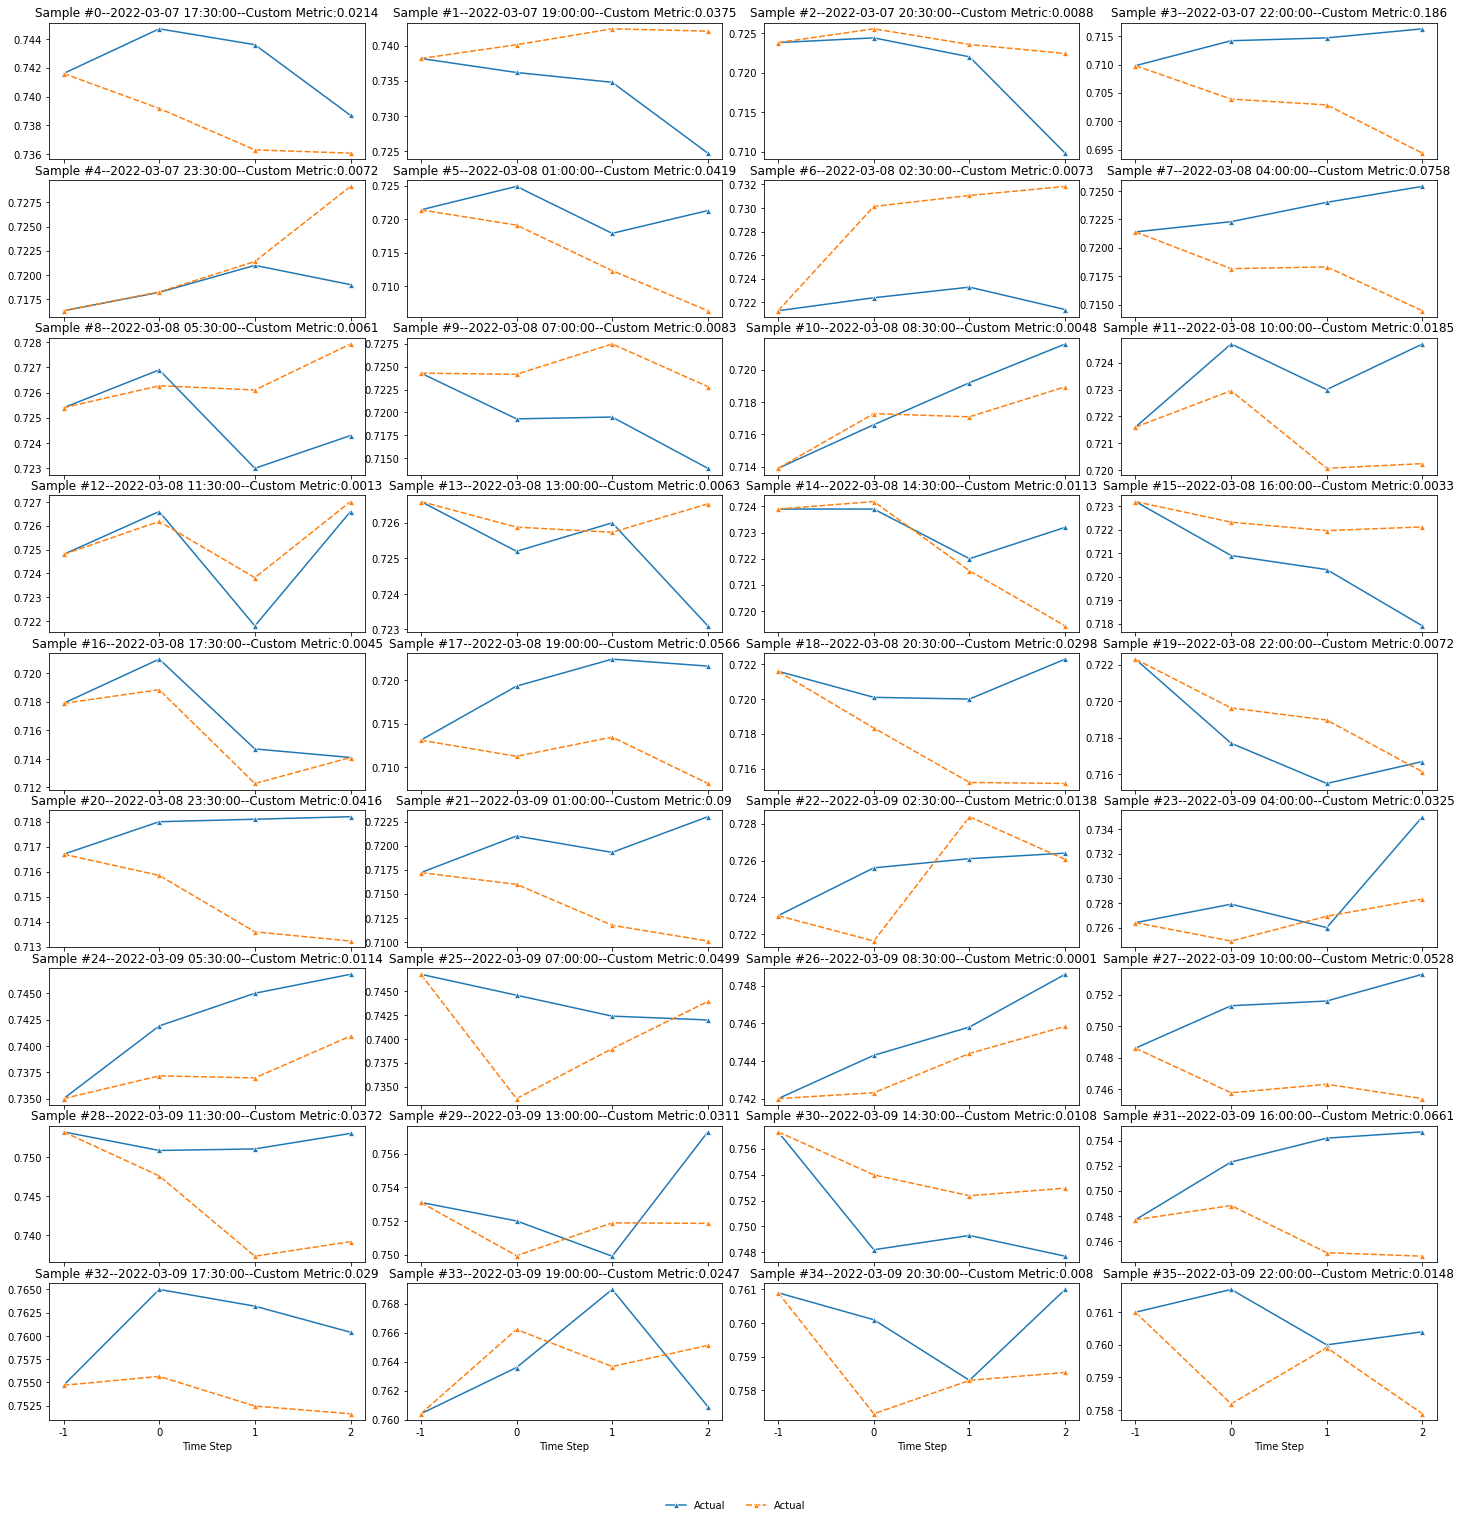

In [11]:

sExchangeRate = 'RPLUSD'

sSimulationFolderPath = 'Data/'+ sExchangeRate +'//Simulation//'
dfActualClose = pd.read_csv(sSimulationFolderPath + 'dfActualClose.csv', index_col = 'timestamp')
dfPredictionClose = pd.read_csv(sSimulationFolderPath + 'dfPredictionClose.csv', index_col = 'timestamp')
dfActualReturnCombinations = pd.read_csv(sSimulationFolderPath + 'dfActualReturnCombinations.csv', index_col = 'timestamp')
dfPredictionReturnCombinations = pd.read_csv(sSimulationFolderPath + 'dfPredictionReturnCombinations.csv', index_col = 'timestamp')

iForwardTimeWindow = dfActualClose.shape[1]
aOutputFeatures = [sExchangeRate +':close']

iNrOfCols = 4
iNrOfRows = int(math.ceil(((len(dfActualClose)/iNrOfCols))))
oFig, aAxises = plt.subplots(iNrOfRows, iNrOfCols, figsize=(20,20), sharex = True)
oFig.tight_layout()


for i in range(0, len(dfActualClose)):    
    dfStepComparision =  pd.DataFrame(
        columns =list(dfActualClose.columns), 
        index = ['Actual', 'Prediction']
    )

    dfStepComparision.loc['Actual'] = dfActualClose.iloc[i].values
    dfStepComparision.loc['Prediction'] = dfPredictionClose.iloc[i].values
    
    dfStepComparision= dfStepComparision.transpose()
    dfStepComparision.index.name = 'Time Step'

    
    fCustomMetric = Calculate_Metrics.fCalculateCustomMetric(dfActualReturnCombinations.iloc[i], 
                                                             dfPredictionReturnCombinations.iloc[i]
                                                            )
    sDateTime = dfActualClose.iloc[i].name
    sTitleName = 'Sample #' + str(i) + '--' + str(sDateTime)+ '--Custom Metric:' + str(round(fCustomMetric,4))

    iSampleGraphRow =  int(i/iNrOfCols)
    iSampleGraphCol = int(i%iNrOfCols)    
    
    sns.lineplot(ax =aAxises[iSampleGraphRow,iSampleGraphCol] , data = dfStepComparision, legend = False,  marker = '^').set_title(sTitleName)
    
    

oFig.legend(aAxises[0][0].lines, ['Actual', 'Actual'], frameon=False, loc='lower center', ncol=2,  bbox_to_anchor=(0.5,-0.05))


# if aAxises.ndim == 2:
#     for a, axs in enumerate(reversed(aAxises)):
#         for b, ax in enumerate(reversed(axs)):
#             if ax in aAxises.flat[i - (iNrOfCols * iNrOfRows):] :
#                 # one can use get_lines(), get_images(), findobj() for the propose
#                 ax.set_axis_off()
#                 # now find the plot above
#                 aAxises[-2-a][-1-b].xaxis.set_tick_params(which='both', labelbottom=True)
#             else:
#                 break # usually only the last few plots are empty, but delete this line if not the case

# ___

In [ ]:
# ## Single Time Step Comparison
# iComparisionTimeStep = 0

# dfTestComparision = pd.DataFrame(dfPredictionClose.iloc[:,iComparisionTimeStep])
# dfTestComparision = dfTestComparision.join(dfActualClose.iloc[:,iComparisionTimeStep], how = "inner", lsuffix="prediction")
# dfTestComparision.columns = ["Prediction", "Actual"]

# plt.figure(figsize = (20,10))
# oFig = sns.scatterplot(data = dfTestComparision, x = "Actual", y ="Prediction")
# oFig.get_figure().savefig(sModelName + '\closing price scatter.png')